In [1]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt

from scipy import special
from tqdm import tqdm
from ipywidgets import interact
from scipy import stats
from matplotlib.colors import LogNorm

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-05 06:59:43.896968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 06:59:44.152454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 06:59:44.152561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 06:59:44.189422: E external/local

## Basic of Radio Interferometry
Interferometric radio telescope observation is a technique used to enhance the resolution and sensitivity of observations. It involves combining signals from multiple separate telescopes or antenna elements and <i>"virtually simulate"</i> a telescope that can capture larger wavelength. 

This technique is based on the principle of interferometry, where the signals collected by separate telescopes are combined and analyzed to extract detailed information about astronomical objects.

<img src="images/interferometry.png" alt="Drawing" style="width: 500px;"/>

Relevant aspect of an radio interferometry telescope can be summarized as:

- __Baseline Lengths:__ In an interferometric array, each pair of antennas forms a baseline. The length of each baseline determines the spatial resolution and sensitivity of the interferometric observations. Longer baselines provide higher spatial resolution but may introduce larger geometrical delays.
 - __Delay Calculation:__ The geometrical delay for each baseline is calculated based on the difference in the distances traveled by the signal from the source to each antenna. This calculation takes into account the geometry of the array, the position of the source in the sky, and the Earth's rotation.
 - __Delay Compensation:__ Geometrical delays need to be compensated during data processing to ensure accurate interferometric measurements. Delay compensation techniques, such as fringe tracking and phase correction, are used to align the signals received by different antennas properly.
 - __Wide-field Imaging:__ Geometrical delays become more complex when observing extended sources or large fields of view. In such cases, corrections for the variation in delay across the field of view are necessary to accurately reconstruct images of the sky.
 - __Phase Referencing:__ In some interferometric observations, a nearby calibrator source with a known position is used as a reference to correct for geometrical delays. By periodically observing the calibrator, astronomers can track and compensate for changes in the delay introduced by the Earth's rotation and atmospheric effects.
 
and more...

## Visibility explained

It turn out that a simple two antenna radio interferometer can be mathematically represented by a correlation operation, as the signal detectect by two separated radio anteannas

Let assume that we have two antennas located at $\vec{r}_1$ and $\vec{r}_2$ with baseline $ b = |\vec{b}| = |\vec{r}_1 - \vec{r}_2|$. Let consider the position of a source in the sky with the vector $\hat{\vec{s}} = (\alpha,\,\delta)$ and phase center $\hat{\vec{s}}_0 = (\alpha_0,\,\delta_0)$.

With the electric field from a source in the sky being $E_\nu(\vec{s},\,t) \propto \sqrt{I_{\rm sky}(\vec{s})} $ and a geometrical delay, $ \tau $, the _Visibility_, $V$, is defined as:

$$ V_\nu(\vec b) = \left<I_\nu(\hat{\vec{s}})\cdot I^*_\nu(\hat{\vec{s}}) \right> = \int{A(\hat{\vec{s}})\cdot I_{\rm sky}(\hat{\vec{s}})\cdot e^{-2\pi i \vec{b} \cdot \hat{\vec{s}} / \lambda} d\Omega} $$

where here:
 - $\hat s$ is a normalized vector pointing to the sky image.
 - $A(\hat s)$ is beam pattern, also referred as primary beam.

Moreover, remember that we express the position of sources in the reference frame of the phase centre with the coordinate system $l$, $m$.

This is just a reminder that in a dicrete case we have to express the _Visibility_ as a discrete sum,
$$V(u,v)=\mathcal{F}\{I(l,m)\} = \mathcal{F}\{\sum_k A_k \delta(l-l_k,m-m_k)\} = \sum_k A_k e^{-2\pi i (ul_i+vm_i)}$$


Let consider two dish antennas 1 and 2 at a give distance $|\mathbf{b}|$ to each other. As we mentioned above there would be some time delay, $\tau$, between a signal reached by antenna 1 and antenna 2

In [2]:
# define a 1D sky and get RA coordinate
thet = np.linspace(-np.pi/2, np.pi/2, 2048)

# define a observed frequency
freq = 200. * u.MHz

def plt_fringe(pointing, baseline, FoV):
    # baseline in metre units
    baseline *= u.m

    offset = 10 # needed just for a visualy nicer plot
    
    # calculate fringe pattern
    fringe_pattern = np.exp(-2j * np.pi * np.sin(thet)  * (baseline / cst.c * freq).cgs.value)
    
    # define the beam    
    beam_pattern = offset/3 * np.exp(-(thet+pointing)**2 / (2 * FoV**2)) # Gaussian beam pattern

    # plot fringe pattern
    ax2 = plt.subplot(111, projection='polar')    
    plt.polar(thet, fringe_pattern.real+offset)
    
    # plot the combination with the beam
    plt.polar(thet, beam_pattern * fringe_pattern.real+offset)
    
    # plot the beam
    plt.polar(thet, beam_pattern)
    
    ax2.set_theta_offset(np.pi/2)
    #ax2.set_yticks([])
    ax2.set_thetamin(-90), ax2.set_thetamax(90)
    plt.show(), plt.clf()
    
interact(plt_fringe, pointing=(-np.pi/2,np.pi/2), baseline=(0, 50), FoV=(0.05, 0.5))

interactive(children=(FloatSlider(value=0.0, description='pointing', max=1.5707963267948966, min=-1.5707963267…

<function __main__.plt_fringe(pointing, baseline, FoV)>

## Simulate a 1D Inteferometric Telescope
Here we will create a simulation of 

In [3]:
# define a 1D sky and get RA coordinate
thet = np.linspace(-np.pi/2, np.pi/2, 2048)

# define a observed frequency
freq = 100. * u.MHz
bl = 8 * u.m

# position of the two sources
mean_A = thet[768]
mean_B = thet[-768]
std_A = 0.05
std_B = 0.1

# create two gaussian sources
source_A = (1 / (std_A * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((thet - mean_A) / std_A) ** 2)
source_B = (1 / (std_B * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((thet - mean_B) / std_B) ** 2)

# Combine the two distributions by adding their PDFs
I_sky = source_A + source_B

# calculate fring patter for the two antennas
fringe_pattern = np.exp(-2j * np.pi * np.sin(thet) * (bl / cst.c * freq).cgs.value)

(None, None)

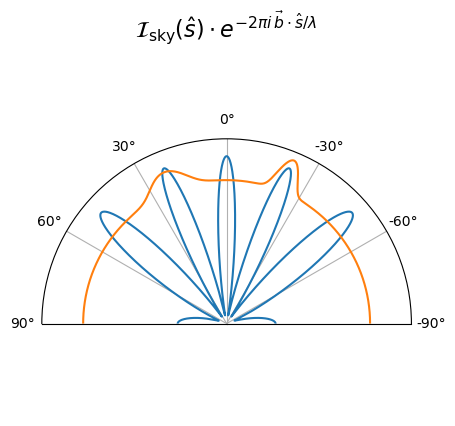

In [5]:
# plot fringe pattern and sky model
ax = plt.subplot(111,projection='polar')
ax.set_title(r'$\mathcal{I}_{\rm sky}(\hat s )\cdot e^{-2\pi i\, \vec b \cdot \hat s / \lambda}$', fontsize=16)
plt.polar(thet, fringe_pattern.real)
plt.polar(thet, np.log10(I_sky.real+5))
ax.set_theta_offset(np.pi/2)
ax.set_yticks([])
ax.set_thetamin(-90), ax.set_thetamax(90)

Now let assume we have a series of antenna at given distance to each other

In [6]:
# define 
baselines = np.linspace(0, 200, 250) * u.m

# visibilities
V = [] 

# loop trought different baseline
for bl in baselines:
    # calculate fringe patter
    fringe_pattern = np.exp(-2j * np.pi * np.sin(thet) *( bl  / cst.c * freq).cgs.value)
    
    # discrete integration
    V.append(np.sum(I_sky * fringe_pattern))


In [8]:
UMAX = 250
URES = 0.5
USIZE = int(UMAX / URES)

u_coord = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)
u_coord = np.fft.fftshift(u_coord)
u_plane = np.zeros(USIZE, dtype=complex)
u_sampl = np.zeros(USIZE, dtype=complex)

for bl, vis in zip(baselines, V):
    u_bin = int(np.around((bl * freq / cst.c).cgs.value / URES))
    u_plane[u_bin] += vis
    u_sampl[u_bin] += 1
    u_plane[-u_bin] += vis.conj()
    u_sampl[-u_bin] += 1
u_plane /= np.where(u_sampl > 0, u_sampl, 1)

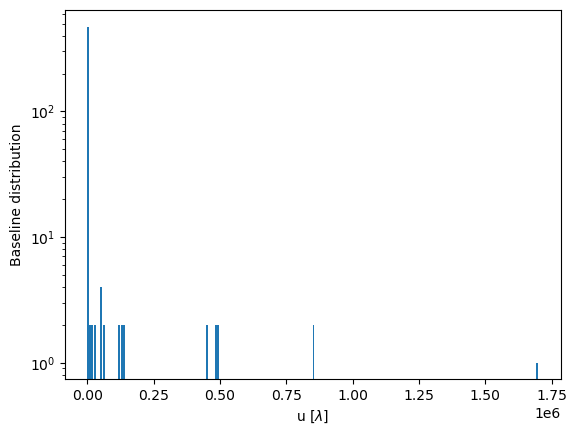

In [7]:
plt.hist(np.abs(u_plane**2), bins=250);
plt.xlabel(r'u [$\lambda$]'), plt.ylabel('Baseline distribution');
plt.yscale('log')

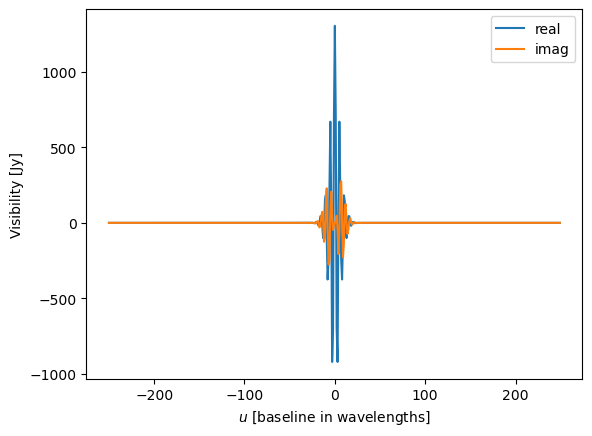

In [8]:
plt.figure()
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.real), label='real')
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.imag), label='imag')
plt.ylabel('Visibility [Jy]')
plt.xlabel('$u$ [baseline in wavelengths]')
_ = plt.legend(loc='best')

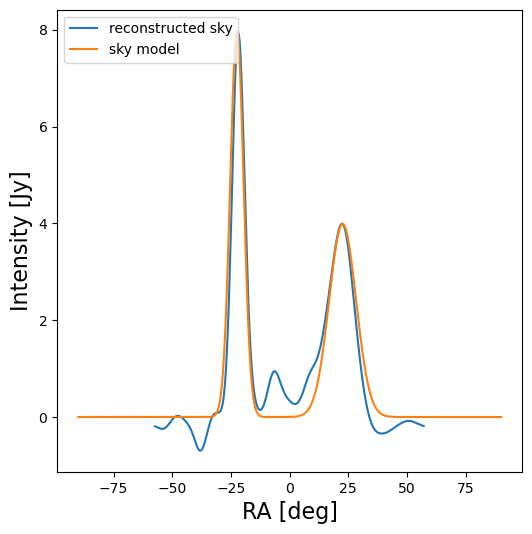

In [9]:
I_sky_reconstruct = np.fft.ifft(u_plane)
x = np.fft.fftfreq(USIZE, URES)
plt.figure(figsize=(6,6))
plt.plot(np.rad2deg(np.fft.fftshift(x)), np.exp(-1)*np.fft.fftshift(I_sky_reconstruct), label='reconstructed sky')
plt.plot(np.rad2deg(thet), I_sky, label='sky model')
plt.ylabel('Intensity [Jy]', fontsize=16), plt.xlabel('RA [deg]', fontsize=16)
plt.legend(loc=2)
plt.show()